In [1352]:
# required imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


Import Data and remove irrelevant columns/incorrect data

In [1353]:
bodydata = pd.read_csv('bodyfat.csv')
bodydata = bodydata.drop(["Density"], axis = 1)
bodydata = bodydata[bodydata["Age"] < 60]
bodydata

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,17.0,56,167.75,68.50,37.4,98.6,93.0,97.0,55.4,38.8,23.2,32.4,29.7,19.0
230,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
231,16.1,57,182.25,71.75,39.4,103.4,96.7,100.7,59.3,38.6,22.8,31.8,29.1,19.0
232,15.4,58,175.50,71.50,38.0,100.2,88.1,97.8,57.1,38.9,23.6,30.9,29.6,18.0


In [1354]:
# max and min values show incorrect height and bodyfat values of 29.5 inches and 0%
bodydata.describe().loc[['min', 'max']]

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
min,0.0,22.0,118.50,29.50,31.1,79.3,69.4,85.0,47.2,33.0,19.1,24.8,21.0,15.8
max,47.5,58.0,363.15,77.75,51.2,136.2,148.1,147.7,87.3,49.1,33.9,45.0,34.9,21.4


In [1355]:
# remove incorrect values
bodydata = bodydata.loc[bodydata['BodyFat'] != 0.0]
bodydata = bodydata.loc[bodydata['Height'] != 29.50]

Creating new features 

In [1356]:
#BMI calculation
squareH = bodydata["Weight"] / bodydata["Height"]**2
bodydata["BMI"] = squareH * 703

#converting waist in cm to waist in inches 
bodydata["waist"] = bodydata["Abdomen"] / 2.54

#calculating height to waist ratio due to research suggesting this ratio acts as a indicator for estimating bodyfat
bodydata["heightToWaistRatio"] = round(bodydata["waist"]/bodydata["Height"],2)

#calculating upper body frame size from wrist
bodydata["FrameSizeU"] = np.where( (bodydata["Wrist"] < 16.5),0, np.where( (bodydata["Wrist"] > 18.5), 2, 1))

#calculating lower body frame size from ankle
bodydata["FrameSizeL"] = np.where( (bodydata["Ankle"] < 23),0, np.where( (bodydata["Ankle"] > 29), 2, 1))

#replacing target value with binary yes or no, this value indicating if the individual is above 30% body fat
bodydata["Below22%Fat?"] = np.where( (bodydata["BodyFat"] < 22),'yes', 'no')

#selecting required columns 
bodydata = bodydata[["Weight", "Height", "waist", "Ankle", "Wrist", "heightToWaistRatio", "BMI", "FrameSizeU", "FrameSizeL",  "Below22%Fat?"]]
bodydata


,Weight,Height,waist,Ankle,Wrist,heightToWaistRatio,BMI,FrameSizeU,FrameSizeL,Below22%Fat?
0,154.25,67.75,33.543307,21.9,17.1,0.50,23.624460,1,0,yes
1,173.25,72.25,32.677165,23.4,18.2,0.45,23.332048,1,1,yes
2,154.00,66.25,34.606299,24.0,16.6,0.52,24.666315,1,1,no
3,184.75,72.25,34.015748,22.8,18.2,0.47,24.880784,1,0,yes
4,184.25,71.25,39.370079,24.0,17.7,0.55,25.514854,1,1,no
...,...,...,...,...,...,...,...,...,...,...
229,167.75,68.50,36.614173,23.2,19.0,0.53,25.132559,2,1,yes
230,147.75,65.75,34.015748,21.3,16.9,0.52,24.026544,1,0,yes
231,182.25,71.75,38.070866,22.8,19.0,0.53,24.887373,2,0,yes
232,175.50,71.50,34.685039,23.6,18.0,0.49,24.133503,1,1,yes


Data exploration 

(60.0, 80.0)

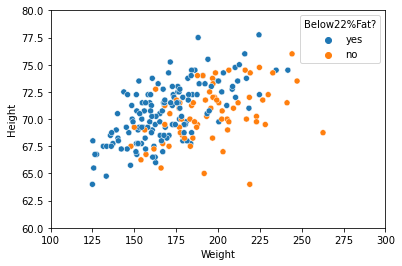

In [1357]:
# This plot showed how neither height or weight were good indictors of being in a healthy body fat range
sns.scatterplot(data=bodydata, x="Weight", y="Height", hue="Below22%Fat?")
plt.xlim(100, 300)
plt.ylim(60, 80)

(18.0, 35.0)

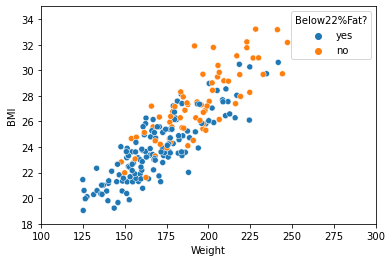

In [1358]:
# By calculating BMI and plotting against weight, it can be seen that lower BMI levels tended to be more 
# prevelant at lower weights as expected. Bodyfat showed a pattern with individuals at lower 
# bodyfats also having a lower weight and BMI.
sns.scatterplot(data=bodydata, x="Weight", y="BMI", hue="Below22%Fat?")
plt.xlim(100, 300)
plt.ylim(18, 35)

(0.3, 0.8)

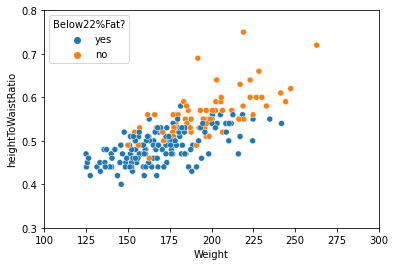

In [1359]:
# Replacing BMI with height to waist ratio showed how most indivduals with a 0.5 ratio or lower were in a healthy bodyfat range 
sns.scatterplot(data=bodydata, x= "Weight", y="heightToWaistRatio", hue="Below22%Fat?")
plt.xlim(100, 300)
plt.ylim(0.3, 0.8)

(18.0, 35.0)

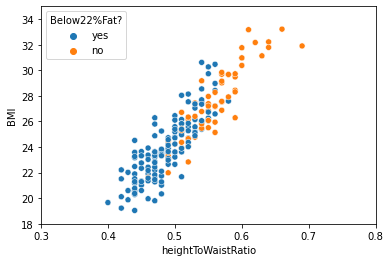

In [1360]:
#Plotting both BMI and height to waist ratio revealed individauls with high levels of tended to be the ones at 
# unhealthy bodyfat levels. Note how a few individuals from the data set had high BMIs (~30) and high ratios (~0.55)
# despite being under 22% bodyfat ( a healthy range for their age). 
sns.scatterplot(data=bodydata, x= "heightToWaistRatio", y="BMI", hue="Below22%Fat?")
plt.xlim(0.3, 0.8)
plt.ylim(18, 35)

In [1361]:
#selecting required columns 
bodydata = bodydata[[ "waist", "Wrist", "heightToWaistRatio", "FrameSizeL", "FrameSizeU", "Below22%Fat?"]]

Selecting dependent and independent variables

In [1362]:
#independent variable
y = bodydata.loc[:, "Below22%Fat?"].values
#dependent variable
X = bodydata.iloc[:, :-1].values


In [1363]:
y

array(['yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes',
       'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'no',
       'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes',
       'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes',
       'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no',
       'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes',
       'no', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes',
       'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 

In [1364]:
X

array([[33.54330709, 17.1       ,  0.5       ,  0.        ,  1.        ],
       [32.67716535, 18.2       ,  0.45      ,  1.        ,  1.        ],
       [34.60629921, 16.6       ,  0.52      ,  1.        ,  1.        ],
       ...,
       [38.07086614, 19.        ,  0.53      ,  0.        ,  2.        ],
       [34.68503937, 18.        ,  0.49      ,  1.        ,  1.        ],
       [37.36220472, 17.6       ,  0.56      ,  0.        ,  1.        ]])

Splitting data into test and train sets

In [1365]:
# splitting using 20% of data as the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

Training model using training set

In [1366]:
# training using three classifier algorithms to allow for comparison 
clf1 = LogisticRegression()
clf1.fit(X_train, y_train)
clf2 = RandomForestClassifier()
clf2.fit(X_train, y_train)
clf3 = KNeighborsClassifier(n_neighbors=3)
clf3.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

Evaluating performance of the classifiers 

In [1367]:
# evaluating performance of each algorithm and then selecting best based on the highest accuracy
classifiers = [clf1, clf2, clf3]
scores = [0,0,0]
names = ["LogRegression:", "RandomForest:", "KNeighbors:" ]
algorithms_dict = dict([(names[0],classifiers[0]), (names[1],classifiers[1]), (names[2],classifiers[2])])
scores_dict = dict([(names[0],scores[0]), (names[1],scores[0]), (names[2],scores[0])])
for i in names:
    score = algorithms_dict[i].score(X_test, y_test)
    #scores.append(score)
    scores_dict.update({i : score})
    #print (scores_dict)
    print(i, score)
bestalgo = max(scores_dict, key=scores_dict.get)
print("Highest Accuracy - ", bestalgo, scores_dict[bestalgo])

LogRegression: 0.7906976744186046
RandomForest: 0.8372093023255814
KNeighbors: 0.8604651162790697
Highest Accuracy -  KNeighbors: 0.8604651162790697


In [1368]:
# showing predictions and real target values side by side
y_pred = algorithms_dict[bestalgo].predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

In [1372]:
# confusion matrix to show breakdown of predictions 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[15,  5],
       [ 1, 22]], dtype=int64)